<a href="https://colab.research.google.com/github/yangligt2/vllm-sim-profiler/blob/main/P_D_external.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2026 Google LLC.

SPDX-License-Identifier: Apache-2.0

In [ ]:
#@title Default title text
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
from sklearn.metrics import r2_score

sns.set_theme(style="whitegrid")

def transform_data(df):
    """
    Applies data transformations to the input DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The transformed DataFrame.
    """
    # Filter out rows where 'model' is 'model' (header row included as data)``````
    df = df[df['model'] != 'model'].copy()

    # Convert relevant columns to numeric, coercing errors
    numeric_cols = ['decode_node', 'decode_dp', 'decode_tp',
                    'prefill_node', 'prefill_dp', 'prefill_tp',
                    'total_token_throughput', 'output_throughput',
                    'input_len', 'output_len', 'request_rate', 'max_curr']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    map_dict = {'true': 'P/D Disaggregated', 'false': 'Aggregated'}

    df['decode_gpu_cnt'] = df['decode_node'] * df['decode_dp'] * df['decode_tp']
    df['prefill_gpu_cnt'] = df['prefill_node'] * df['prefill_dp'] * df['prefill_tp']
    df['total_gpu_cnt'] = df['prefill_gpu_cnt'] + df['decode_gpu_cnt']
    df['system_type'] = df['pd_enabled'].astype(str).str.lower().map(map_dict)
    df['inpu_throughput'] = df['total_token_throughput'] - df['output_throughput']

    # Add new columns
    df['per gpu throughput'] = df['total_token_throughput'] / df['total_gpu_cnt']
    df['per user throughput'] = df.apply(lambda row: row['total_token_throughput'] / row['max_curr'] if row['max_curr'] != 0 else 0, axis=1)
    df['per gpu output throughput'] = df['output_throughput'] / df['total_gpu_cnt']
    df['per decode_gpu output throughput'] = df['output_throughput'] / df['decode_gpu_cnt']
    df['per user output speed'] = df.apply(lambda row: row['output_throughput'] / row['max_curr'] if row['max_curr'] != 0 else 0, axis=1)
    df['1/TPOT'] = 1000 / df['mean_tpot_ms']

    return df

def load_and_process_data(file_ids):
    """
    Loads data from multiple file IDs, combines them into a single DataFrame,
    and applies data transformations.

    Args:
        file_ids (list): A list of Google Drive file IDs.

    Returns:
        pandas.DataFrame: The combined and processed DataFrame.
    """
    dataframes = []
    for file_id in file_ids:
        raw = drive.LoadFile(file_id=file_id)
        b = io.BytesIO(raw)
        df = pd.read_csv(b)
        dataframes.append(df)

    combined_df = pd.concat(dataframes, ignore_index=True)

    combined_df = transform_data(combined_df)

    return combined_df

def csv_text_to_df(csv_text):
  csv_file_like_object = io.StringIO(csv_text)
  df = pd.read_csv(csv_file_like_object)
  df = transform_data(df)
  return df

In [4]:
raw_data_csv = """
model,tokenizer,hardware,notes,pd_enabled,prefill_node,prefill_dp,prefill_tp,decode_node,decode_dp,decode_tp,goodput,req_rate,input_len,output_len,num_prompts,max_curr,date,endpoint_type,backend,label,model_id,tokenizer_id,num_prompts,request_rate,burstiness,max_concurrency,duration,completed,total_input_tokens,total_output_tokens,request_throughput,request_goodput,output_throughput,total_token_throughput,max_output_tokens_per_s,max_concurrent_requests,mean_ttft_ms,median_ttft_ms,std_ttft_ms,p99_ttft_ms,mean_tpot_ms,median_tpot_ms,std_tpot_ms,p99_tpot_ms,mean_itl_ms,median_itl_ms,std_itl_ms,p99_itl_ms,mean_e2el_ms,median_e2el_ms,std_e2el_ms,p99_e2el_ms,timestamp
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput,true,4,2,4,1,1,8,ttft:5000 tpot:75,inf,6000,500,512,8,20251110-205839,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,8,441.7002153529902,512,3071488,198908,1.1591572342585996,1.1591572342585996,450.32352959357337,7404.107777910913,532.0,13,962.2076442371963,961.3785015244503,311.12268446147704,2058.862057182122,14.521161959756709,15.201987318633002,2.376677834590094,15.29279023637871,15.199576866345502,15.138546004891396,1.4370284192071683,20.300157302990556,6851.063706138234,8541.756158520002,2977.0100248524514,9595.32238804386,2025-11-10T20:58:39.784740
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput,true,4,2,4,1,1,8,ttft:5000 tpot:75,inf,6000,500,512,16,20251110-210333,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,16,234.81650124001317,512,3071488,197547,2.1804259806965995,2.1804259806965995,841.2824437669359,13921.657901965837,1008.0,23,1042.8670563901505,979.1873234789819,421.882692719351,2491.3883033039733,15.229918784161645,16.12187546491483,3.0202424397709806,16.227549790725057,16.116998568765666,15.97001397749409,1.6879552794538404,21.509422222152352,7243.787425299729,9010.60225701076,3230.79457473966,10464.60130758991,2025-11-10T21:03:33.493173
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput,true,4,2,4,1,1,8,ttft:5000 tpot:75,inf,6000,500,512,32,20251110-210652,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,32,140.43926329398528,512,3071488,206018,3.6457041142989812,3.6457041142989812,1466.954434022749,23337.533415702335,1824.0,43,1266.1453500554671,1037.3260849737562,570.242977017151,3270.5631189950486,17.406035198936987,18.030890948572836,2.4898293160365648,18.36721050196779,18.024740549434117,17.76565401814878,2.323194033617312,25.146413033362474,8498.114531668762,10039.414015976945,3444.53738223276,12156.254104995749,2025-11-10T21:06:52.941844
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput,true,4,2,4,1,1,8,ttft:5000 tpot:75,inf,6000,500,640,64,20251110-210951,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,640,inf,1.0,64,114.73096270096721,640,3839360,263322,5.57826749582922,5.438810808433489,2295.1258649011593,35759.15257238065,3059.0,80,1881.9112496210437,1587.7948874840513,1136.3989150868824,6193.31516161212,21.450490545005447,22.345442234357456,2.7561449885879643,22.632386603472916,22.011226360800368,21.689932502340525,2.9932228719580034,30.749802992795576,10914.217600023221,12336.60768601112,4142.017453192879,16774.086096936953,2025-11-10T21:09:52.123391
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput,true,4,2,4,1,1,8,ttft:5000 tpot:75,inf,6000,500,1280,128,20251110-211402,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,1280,inf,1.0,128,158.5324163250043,1280,7678720,547742,8.074058477579097,7.336039069862884,3455.0788583016642,51891.35566529867,3889.0,146,2988.052081287424,2618.2808709563687,1858.3248423121015,10481.80887089926,28.278056822517993,28.845767242454166,2.8309814522728,31.093042401385908,28.658393926622935,28.00937250140123,4.6694896957398955,43.749930238118395,15222.991786063994,16577.29133751127,5021.156526064672,25508.97213105054,2025-11-10T21:14:03.053259
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput,true,4,2,4,1,1,8,ttft:5000 tpot:75,inf,6000,500,2560,256,20251110-212052,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,2560,inf,1.0,256,258.90992126299534,2560,15357440,1102231,9.887608738637732,3.2714080475102185,4257.198776405237,63572.96359949299,4876.0,274,7132.117221531962,6290.224381984444,4111.290723789461,24095.833376697265,41.09401104624053,42.832428358732265,4.5931373258113295,43.96886369538212,41.41294493745016,40.9425730467774,7.524171796321022,65.33398001338355,24921.419327525586,26449.90187548683,7628.800336131385,43162.71384480816,2025-11-10T21:20:52.599236
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput,true,4,2,4,1,1,8,ttft:5000 tpot:75,inf,6000,500,5120,512,20251110-213316,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,5120,inf,1.0,512,483.33966646000044,5120,30714880,2222649,10.5929646484409,0.07241284427645146,4598.523883377445,68145.7188093744,5242.0,531,25857.63357766415,25593.853412021417,5200.3887484511,43500.00303981594,47.14765750779387,49.003737906892894,5.37264637568734,52.596822590130905,47.51475709973259,46.65581596782431,9.07197122541269,80.21098139463018,46436.80347453339,49166.635220026365,9350.206981384099,63968.934312040226,2025-11-10T21:33:17.314150
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-100,true,4,2,4,1,1,8,ttft:12000 tpot:100,inf,6000,500,512,8,20251110-222626,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,8,446.4392291820259,512,3071488,198186,1.146852620765643,1.146852620765643,443.9260419903511,7323.894913963444,535.0,13,1073.8873191957055,976.8250210036058,264.8659610269325,2187.086841724812,14.503013399472042,15.163769899776021,2.293536496438668,15.233150469012072,15.159033453887846,15.105637983651832,1.3893717918336528,19.978340925299552,6926.043693943143,8532.179924979573,2968.3467962005425,9648.914685530472,2025-11-10T22:26:26.318133
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-100,true,4,2,4,1,1,8,ttft:12000 tpot:100,inf,6000,500,512,16,20251110-223120,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,16,236.2495980010135,512,3071488,198846,2.167199454865542,2.167199454865542,841.6776226605344,13842.707152398923,1007.0,23,1051.973353451558,981.4710775099229,437.88165628641474,2403.6270237294952,15.187369404507328,16.12304125751279,3.040636552289699,16.23505197085962,16.116114710592548,15.943487989716232,1.6973385748217318,21.71668203780427,7294.103085041343,9014.363165508257,3212.446824736083,10425.082544464385,2025-11-10T22:31:21.020591
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-100,true,4,2,4,1,1,8,ttft:12000 tpot:100,inf,6000,500,512,32,20251110-223442,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,32,143.32564436801476,512,3071488,206478,3.572284654694079,3.572284654694079,1440.6214666639141,22870.757110173694,1824.0,42,1368.686010082456,1045.166194497142,787.3848495192838,4125.3198101435555,17.61346861420927,18.002168625245105,2.5987211167247963,21.917816110814776,18.224331567836142,17.664385988609865,15.170856919768708,24.945156779722303,8698.070478250202,10004.276104009477,3597.364871995856,15017.029825611971,2025-11-10T22:34:42.832595
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-100,true,4,2,4,1,1,8,ttft:12000 tpot:100,inf,6000,500,640,64,20251110-223740,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,640,inf,1.0,64,114.55025324801682,640,3839360,264141,5.587067525850975,5.587067525850975,2305.8962552278167,35822.71434280782,3018.0,77,1834.512897227978,1513.747361022979,1231.8943489192222,7171.322810712154,21.313951639140274,22.283986850205917,3.310611775845893,22.696662936472567,22.085127091835318,21.670709014870226,3.065813609225886,31.88620786881074,10925.613510508356,12349.704989494057,4158.878603280793,18134.12301976292,2025-11-10T22:37:40.942248
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-100,true,4,2,4,1,1,8,ttft:12000 tpot:100,inf,6000,500,1280,128,20251110-224146,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,1280,inf,1.0,128,156.67993953300174,1280,7678720,543449,8.169520640709665,8.11846113670523,3468.529548963302,52477.48387258058,4123.0,145,2914.295223563704,2606.216210522689,1808.5018501769493,10301.893965629866,28.18142985757467,28.90108814225056,2.755648851563827,30.103168775555766,28.607250070272645,28.03539903834462,4.686018718621799,43.44603068428112,15031.454291759337,16569.25522099482,5017.317793288857,24926.976681480304,2025-11-10T22:41:46.329818
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-100,true,4,2,4,1,1,8,ttft:12000 tpot:100,inf,6000,500,2560,256,20251110-224829,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,2560,inf,1.0,256,262.35541356599424,2560,15357440,1101772,9.757755577458456,8.84677761534417,4199.539796127952,62736.31550530122,4845.0,274,7372.858004625459,6683.0963660322595,3909.0856132826975,23126.2477820646,41.157759241075354,42.97690329964055,4.57256748202218,43.99720139736051,41.490667377503286,40.9649980138056,7.405256438620201,64.89040972490325,25188.1074061268,26903.204023983562,7537.549037674941,41615.367863219,2025-11-10T22:48:29.326381
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-100,true,4,2,4,1,1,8,ttft:12000 tpot:100,inf,6000,500,5120,512,20251110-230039,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,5120,inf,1.0,512,483.87636325799394,5120,30714880,2222647,10.581215345024221,0.23146408567240484,4593.419246674229,68070.13010147454,5111.0,531,25965.54606347455,25798.59628851409,5097.535909670946,43339.11327400832,47.01173210073973,48.79124506184466,4.800733366945667,49.68340545966205,47.304181666590544,46.55062599340454,8.20167294975969,75.02316916827112,46452.92215886311,49212.593273463426,9332.419673739709,64815.94430650766,2025-11-10T23:00:40.374351
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-100,false,0,0,0,5,1,8,ttft:12000 tpot:100,inf,6000,500,512,8,20251110-232424,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,8,455.2414307059953,512,3071488,220223,1.1246779521055073,1.1246779521055073,483.7499075127561,7230.692942193695,579.0,15,571.0299003729915,530.0757114891894,135.3325042888593,1306.5153132041423,15.202321995315708,14.794117565204264,4.136989224141009,21.51642569553556,15.131465430402606,13.99303850485012,21.230619003405234,16.647911400068548,7064.2014744710195,7860.258395492565,2379.5136081780597,9742.807129775754,2025-11-10T23:24:24.572852
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-100,false,0,0,0,5,1,8,ttft:12000 tpot:100,inf,6000,500,512,16,20251110-232927,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,16,245.74455808999483,512,3071488,218686,2.083464244251948,2.083464244251948,889.8915267939092,13388.593528061345,1120.0,25,517.0002896113601,531.0295675008092,235.69949524152264,1182.9340043169213,16.366204791998367,16.162172013851393,2.886505460699546,26.26200113663451,16.517783152390678,14.39160801237449,28.941560520963517,17.625470971688628,7555.478890011727,8425.511848472524,2670.358555803536,10736.24531959067,2025-11-10T23:29:27.788624
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-100,false,0,0,0,5,1,8,ttft:12000 tpot:100,inf,6000,500,512,32,20251110-233244,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,32,139.59325721900677,512,3071488,220450,3.6677989338462615,3.6391442546755877,1579.2310057937664,23582.35680993749,2130.0,44,521.8960471487435,529.8532134911511,353.32770691124506,1881.598354738671,20.706975483855608,18.20162130655566,30.640118155861348,39.38169250993036,18.517394945461987,15.12803795048967,36.90186691308557,22.19560984172858,8475.80402824974,9270.733728480991,3074.0680692029914,13201.272566550757,2025-11-10T23:32:44.857348
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-100,false,0,0,0,5,1,8,ttft:12000 tpot:100,inf,6000,500,640,64,20251110-233532,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,640,inf,1.0,64,106.011045783991,640,3839360,276805,6.037106749272802,6.0182407906813244,2611.095833956965,38827.6992228445,3935.0,88,652.2916226605957,536.7617584997788,600.8498633750614,3102.6774940959876,23.00379609057166,21.09071009319727,17.94692674280652,57.32864664133203,22.12876965003584,15.847957984078676,50.3965220779059,408.21859821211547,10200.751556099112,10878.555903967936,3907.532500598992,17501.359128928747,2025-11-10T23:35:33.168426
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-100,false,0,0,0,5,1,8,ttft:12000 tpot:100,inf,6000,500,1280,128,20251110-233935,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,1280,inf,1.0,128,155.5717175459722,1280,7678720,550172,8.227716581079422,8.08630270234212,3536.452567848147,52894.5243377436,7384.0,170,1012.9947625387103,647.5930524757132,934.8424985804876,4672.504827197991,37.71364126582732,31.708308270507636,45.8375117944371,192.69375697789076,32.920658815872,17.24183850456029,81.21819683962192,433.2270872237858,15129.732905144147,15543.438583990792,6256.03818464519,25804.847460325695,2025-11-10T23:39:35.388939
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-100,false,0,0,0,5,1,8,ttft:12000 tpot:100,inf,6000,500,2560,256,20251110-234637,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,2560,inf,1.0,256,283.04046655399725,2560,15357440,1110031,9.04464308997178,8.479352896848544,3921.8102397673692,58180.62413650808,12166.0,285,1770.4488343152207,940.2172544796485,2721.1693093281883,14799.513575818855,67.56810769485749,59.44211070838978,57.50845464508558,419.99617221386876,60.14537980467169,20.872250956017524,130.29804839392517,586.7479867069051,27788.75231165921,28944.23058599932,11657.194156708112,48606.37571328141,2025-11-10T23:46:37.735960
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-100,false,0,0,0,5,1,8,ttft:12000 tpot:100,inf,6000,500,5120,512,20251110-235958,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,5120,inf,1.0,512,546.191833660996,5120,30714880,2228288,9.373995882878434,2.4661664949682134,4079.680183177231,60314.28148456496,17171.0,538,3558.0641796567534,1312.3943480022717,7661.174049820353,39876.846562738145,126.38255964973847,117.42192496595072,70.82281812334647,562.3334074416199,116.16612888885132,27.181003999430686,190.3993721349599,598.1608092988608,53998.84887517713,57395.77663852833,22720.656278439183,104490.33564412408,2025-11-10T23:59:58.530569
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-60,false,0,0,0,5,1,8,ttft:12000 tpot:60,inf,6000,500,512,16,20251111-001816,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,16,267.26437873300165,512,3071488,218744,1.9157060975622582,1.9007396436750532,818.4554972757004,12310.776376551688,1105.0,25,647.6070994250449,537.9344530228991,343.05889956661986,2179.025942040025,18.566348033767593,17.58792599602948,11.44024744599414,40.49657667803689,17.81708392406683,14.701676031108946,35.41168425260925,18.16609008004889,8241.755950081824,9143.138497514883,2947.3348226645094,11910.637780448884,2025-11-11T00:18:16.898773
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-60,false,0,0,0,5,1,8,ttft:12000 tpot:60,inf,6000,500,512,32,20251111-002147,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,32,151.70353361096932,512,3071488,218721,3.375003784110791,3.3486365670474254,1441.7660208290943,21688.41372170973,2094.0,44,615.76483026613,535.0940244970843,503.4611861837667,2570.03022403689,20.66859482899749,19.75712333472244,7.325227442211075,46.7749181844294,20.26045818084571,15.338427037931979,44.337960316879474,404.4345267931931,9249.608298103227,10094.224805478007,3426.34020405205,14909.179897104623,2025-11-11T00:21:47.762660
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-60,false,0,0,0,5,1,8,ttft:12000 tpot:60,inf,6000,500,640,64,20251111-002450,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,640,inf,1.0,64,118.88195725699188,640,3839360,278046,5.383491446195543,5.299374392348738,2338.8410353888844,34634.40622111595,3957.0,90,824.6518926433964,549.2140385031234,841.793861590133,4806.005392847003,25.668215904515687,24.299559417824153,16.72995356775111,70.72912826393143,24.55261376060528,16.219062003074214,58.83303477184576,411.06201633810997,11465.370618627185,12212.575616518734,4046.3231320538544,17437.93130115955,2025-11-11T00:24:50.378435
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-60,false,0,0,0,5,1,8,ttft:12000 tpot:60,inf,6000,500,1280,128,20251111-004024,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,1280,inf,1.0,128,168.13124229200184,1280,7678720,547846,7.613100233786179,7.303818036788615,3258.4425864678306,48929.43088895112,6930.0,147,1273.7649126466295,745.9118239639793,1622.9559145462604,8942.357250970688,41.75732676448351,35.19675107610987,49.887035158941515,240.92081316110495,35.417226245958275,17.33412902103737,88.13967890082762,563.4579982317518,16396.3390763156,17367.44818498846,6651.028058325551,27577.76043535036,2025-11-11T00:40:24.819334
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-60,false,0,0,0,5,1,8,ttft:12000 tpot:60,inf,6000,500,2560,256,20251111-004742,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,2560,inf,1.0,256,285.41951897204854,2560,15357440,1109141,8.969253431650214,4.540684549772921,3886.002625169512,57692.553961639154,11905.0,285,1912.8317094909107,960.2370409993455,3075.931418345624,16370.939911484018,68.1598323348623,58.75946348894645,58.225998916567484,412.08206208888436,60.32558452825426,20.85300802718848,130.84319925206444,587.2748059919104,27988.353137771377,28695.57385749067,12214.556742834968,52702.19853796412,2025-11-11T00:47:43.302171
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-nonpd-goodput-12k-60,false,0,0,0,5,1,8,ttft:12000 tpot:60,inf,6000,500,5120,512,20251111-010108,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,5120,inf,1.0,512,545.9157068590284,5120,30714880,2231634,9.378737295283821,0.6374610505388223,4087.8728564889484,60350.91789089659,16614.0,541,3611.710135871863,1315.2476254908834,7763.059096780918,40219.53812396154,126.96287122584843,115.56803368329199,72.0278084361733,558.4037124016326,115.77502905942173,27.109202492283657,190.09752400557161,598.1189235288184,53955.8931840577,56620.32378150616,22440.363218391874,98916.13941284842,2025-11-11T01:01:09.235386
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,512,16,20251111-012758,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,16,241.2520935619832,512,3071488,199553,2.122261375810426,2.122261375810426,827.155516263863,13558.601509750606,1008.0,27,1189.743192423748,995.0015390058979,418.9189040579488,2885.1488376135194,15.542262466893117,16.134833267380742,2.1644434019239824,16.21903440421741,16.120185174517445,15.98280796315521,1.6179703685349425,21.226959171472117,7455.803636090877,9027.23322249949,3093.9391989647775,10480.873116618022,2025-11-11T01:27:58.419714
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,512,32,20251111-013116,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,32,139.60332561604446,512,3071488,203407,3.667534406796083,3.667534406796083,1457.035490396818,23458.57439676652,1823.0,43,1300.4357844428114,1037.728455499746,629.8020709729503,3469.6473600977324,17.44798773205367,18.074755170424556,2.150004271255776,18.360243414412952,18.012166829219712,17.765158030670136,2.1383461295463584,24.079726636409756,8435.540240456476,10041.552151029464,3506.919074236798,12229.240957567816,2025-11-11T01:31:16.347329
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,640,64,20251111-013414,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,640,inf,1.0,64,115.06881700997474,640,3839360,269105,5.561889108015437,5.561889108015437,2338.6440131445224,35704.41677212913,2967.0,80,1813.1346535726152,1528.3716380072292,1103.7497639131147,6122.704674298876,21.57734589424425,22.212352396855934,2.293809062879383,22.535050493193314,21.998230695783576,21.604267501970753,3.036690009003801,31.57218058593571,11038.573527641256,12321.26516351127,3912.2416832031763,16817.09691559081,2025-11-11T01:34:15.208374
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,1280,128,20251111-013825,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,1280,inf,1.0,128,160.00478501303587,1280,7678720,550246,7.999760756503102,7.968511691048011,3438.934654080317,51429.499432342425,4071.0,147,2936.187617675432,2569.831864500884,1881.6809463686827,10308.76437104016,28.489859375416145,29.165706186432143,2.7484347268104377,31.0460742685257,28.87716149764671,28.25081697665155,4.915178138297489,44.36896950646759,15321.015186391924,16622.831161512295,5021.956379384828,24970.651582896244,2025-11-11T01:38:26.257316
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,2560,256,20251111-014512,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,2560,inf,1.0,256,261.6491318200133,2560,15357440,1103733,9.784095143724793,8.866836224000593,4218.370580183124,62913.15734738815,4842.0,273,7247.077436621112,6402.257370529696,4038.751624880763,23150.906958907715,41.349677028986804,43.092985085607324,4.4973374839555165,44.261671753895286,41.62998573329089,40.883614972699434,8.122726773863567,69.39086150145158,25154.036487378016,26854.661393008428,7684.724569804502,43235.54608555332,2025-11-11T01:45:13.505853
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,5120,512,20251111-015744,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,5120,inf,1.0,512,483.11416857200675,5120,30714880,2230149,10.597909010066383,0.22561954728461636,4616.194566580182,68193.05071796842,5303.0,533,26013.528741994796,25821.539480501087,5142.071697798616,44125.149671942556,46.579734084972024,48.668852160329685,4.996046401626624,49.89030746772012,46.883737110312495,46.19884502608329,8.526922326121566,75.06297160871334,46388.07410505094,48988.68737198063,9097.226273871489,63871.75177276027,2025-11-11T01:57:44.879824
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60-1,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,512,50,20251111-021105,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,512,inf,1.0,50,109.78057093801908,512,3071488,213068,4.663848945448367,4.663848945448367,1940.8534513843608,29919.283275129117,2392.0,64,1879.505797695856,1570.5676609941293,1031.035422578752,5375.955642580519,19.81056241711516,20.159158232901778,1.4662918807368082,20.706242298739955,20.10628721247897,19.749645492993295,2.8129360609927754,28.17482799000574,10226.599020936304,11332.769105996704,3704.6299312490423,15254.930498904432,2025-11-11T02:11:06.161865
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60-1,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,1000,100,20251111-021447,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,1000,inf,1.0,100,139.71625232498627,1000,5999000,422942,7.1573634660193655,7.121576648689269,3027.1496190451626,45964.17305169534,3502.0,117,2496.292426600936,2124.616690503899,1648.1065871359992,10166.107106193085,25.38326482694553,26.211145118262454,2.841543800531274,26.503961137449277,25.911369115183767,25.339494517538697,3.9697231286633463,38.22880768624602,13427.314107943384,14801.005390007049,4608.709625043352,22135.81350253836,2025-11-11T02:14:48.284922
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60-1,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,1500,150,20251111-021922,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,1500,inf,1.0,150,175.75890033802716,1500,8998500,641431,8.534418439778213,8.380798907862204,3649.493702830252,54847.46992305975,4246.0,166,3531.7043005728237,3049.430156010203,2275.68113080128,13207.169880875153,30.779815972193116,31.739692945250198,2.78513547848148,32.40555128654076,31.1241579745527,30.47602903097868,5.305370318983772,48.67564099840814,16809.91298172165,18303.688326996053,5496.02001063541,28302.464955417665,2025-11-11T02:19:22.991051
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60-1,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,2000,200,20251111-022505,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,2000,inf,1.0,200,221.0621496780077,2000,11998000,865844,9.047229491403835,8.631056934799258,3916.744685877531,58191.07440480914,4488.0,217,5331.2491849249345,4577.239206497325,3343.313259739582,19686.577497961116,36.67280812089119,37.91091310626497,3.7360415911626643,38.86207602985207,37.0028024962693,36.45547849009745,6.316930200525436,57.29225166433023,21313.57330558903,22787.760388484458,6596.872430373434,37220.923999916995,2025-11-11T02:25:05.404712
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60-1,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,2500,250,20251111-023147,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,2500,inf,1.0,250,254.71485648298403,2500,14997500,1076063,9.814896682977775,8.95118577487573,4224.578867750045,63104.14406893372,4815.0,268,7003.941751463665,6238.708613003837,3812.0506861394997,21335.329190365068,40.81753073735584,42.29897713828281,4.247630098762045,43.953512141293004,41.09159225553335,40.42894998565316,7.51554610445589,65.0379520037677,24649.706634970455,26170.61191299581,7438.4259819596655,41147.485882245805,2025-11-11T02:31:47.882676
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60-1,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,3000,300,20251111-023928,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,3000,inf,1.0,300,293.12505058100214,3000,17997000,1293710,10.23453981177559,8.573132848997354,4413.508833297399,65810.51316413916,5017.0,320,9020.915999243463,8226.49708300014,4436.491046653965,26527.03289107593,44.41933314745553,45.00329321538908,5.421336172769914,49.13294549240779,44.695304575435955,44.24081300385296,8.45421444702387,71.5504672192037,28250.47442587145,30173.996013501892,8159.40326522376,46031.06322495441,2025-11-11T02:39:29.164332
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60-1,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,3500,350,20251111-024817,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,3500,inf,1.0,350,335.12855085899355,3500,20996500,1513109,10.44375357166342,5.609787632779208,4515.010720876019,67167.08839728488,5218.0,369,12440.007813651648,11736.152969970135,4584.672008996014,30128.239160911173,46.057570114103854,48.88153558513915,5.455366305670741,50.032127846719675,46.357251269400365,46.03809502441436,8.795821832169334,74.42461829865348,32434.671395371886,34640.51868050592,8436.847735117111,50210.14431000047,2025-11-11T02:48:18.048767
mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,a3ultra_8xh200,mistral-123B-6000isl-500osl-pd-tp4-goodput-12k-60-1,true,4,2,4,1,1,8,ttft:12000 tpot:60,inf,6000,500,4000,400,20251111-025802,vllm,vllm,,mistralai/Mistral-Large-Instruct-2411,mistralai/Mistral-Large-Instruct-2411,4000,inf,1.0,400,381.5758793230052,4000,23996000,1734813,10.482842906886122,0.7678682429294085,4546.443037955958,67433.01763636581,5229.0,420,16685.601436283425,15919.515645480715,4668.831518193598,35166.78492258825,46.110704672453735,48.59962102405089,5.343638473401193,49.730706112718,46.42035444649153,45.85099598625675,8.785909607102834,74.77348968153818,36771.83936110465,38938.81868448807,8492.23376614891,54815.87148977385,2025-11-11T02:58:02.510795
"""

In [5]:
df = csv_text_to_df(raw_data_csv)

In [6]:
df.loc[df['notes'] == 'mistral-123B-6000isl-500osl-pd-2', 'system_type'] = 'P/D P_TP2'


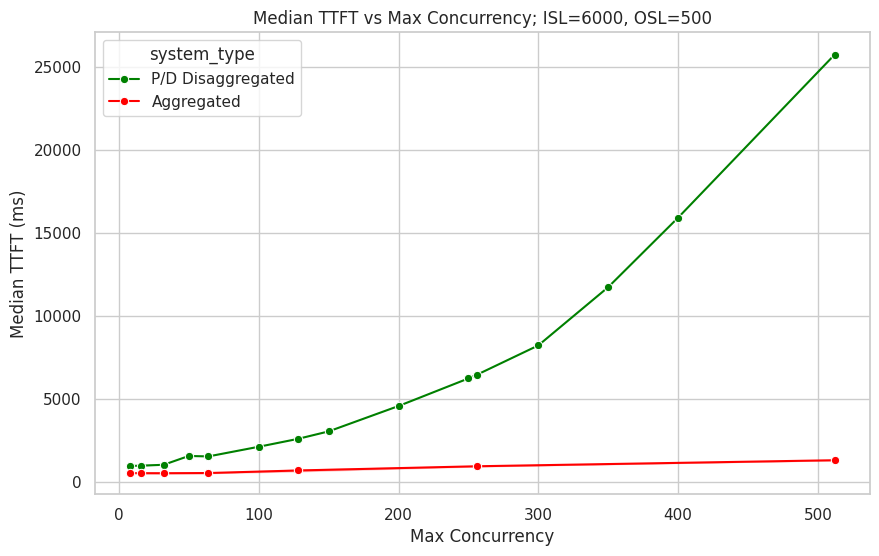

In [7]:
plt.figure(figsize=(10, 6))
palette = {"Aggregated": "red", "P/D Disaggregated": "green", "P/D P_TP2": "orange"}

sns.lineplot(data=df, x='max_curr', y='median_ttft_ms', hue='system_type', marker='o', palette=palette)

plt.title('Median TTFT vs Max Concurrency; ISL=6000, OSL=500')
plt.xlabel('Max Concurrency')
plt.ylabel('Median TTFT (ms)')
plt.grid(True)
plt.show()

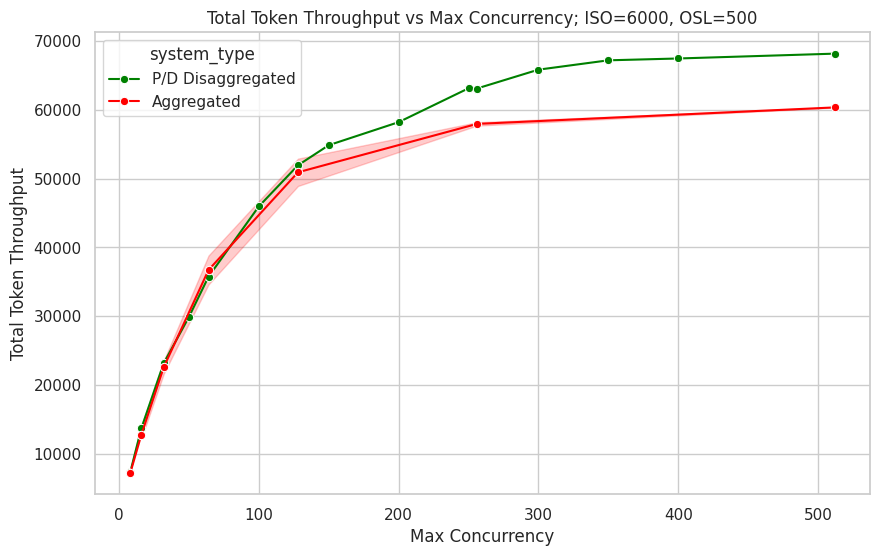

In [8]:
plt.figure(figsize=(10, 6))
palette = {"Aggregated": "red", "P/D Disaggregated": "green", "P/D P_TP2": "orange"}

sns.lineplot(data=df, x='max_curr', y='total_token_throughput', hue='system_type', marker='o', palette=palette)

plt.title('Total Token Throughput vs Max Concurrency; ISO=6000, OSL=500')
plt.xlabel('Max Concurrency')
plt.ylabel('Total Token Throughput')
plt.grid(True)
plt.show()

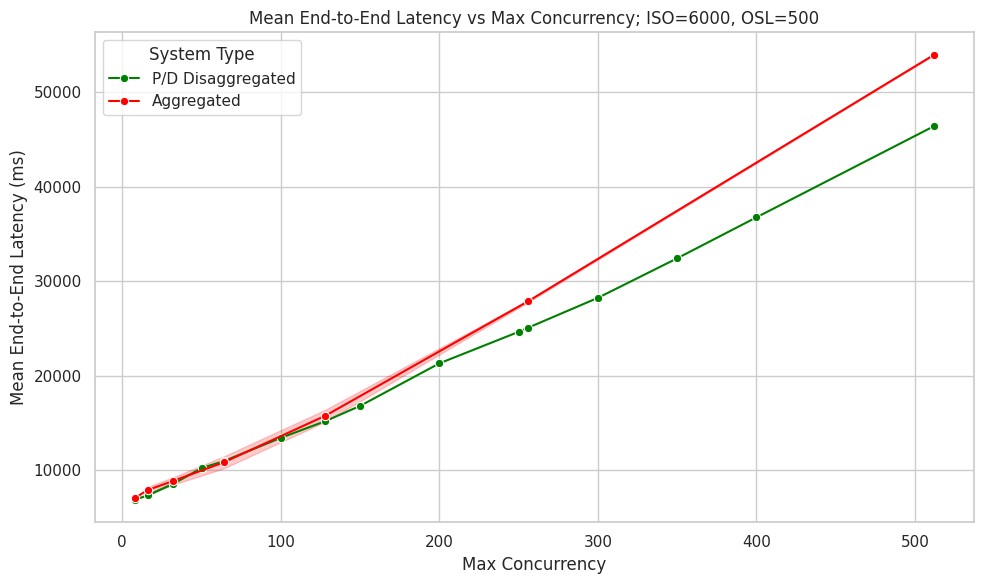

In [9]:
plt.figure(figsize=(10, 6))
palette = {"Aggregated": "red", "P/D Disaggregated": "green", "P/D P_TP2": "orange"}

sns.lineplot(data=df, x='max_curr', y='mean_e2el_ms', hue='system_type', marker='o', palette=palette)

plt.title('Mean End-to-End Latency vs Max Concurrency; ISO=6000, OSL=500')
plt.xlabel('Max Concurrency')
plt.ylabel('Mean End-to-End Latency (ms)')
plt.grid(True)
plt.legend(title='System Type')
plt.tight_layout()
plt.show()

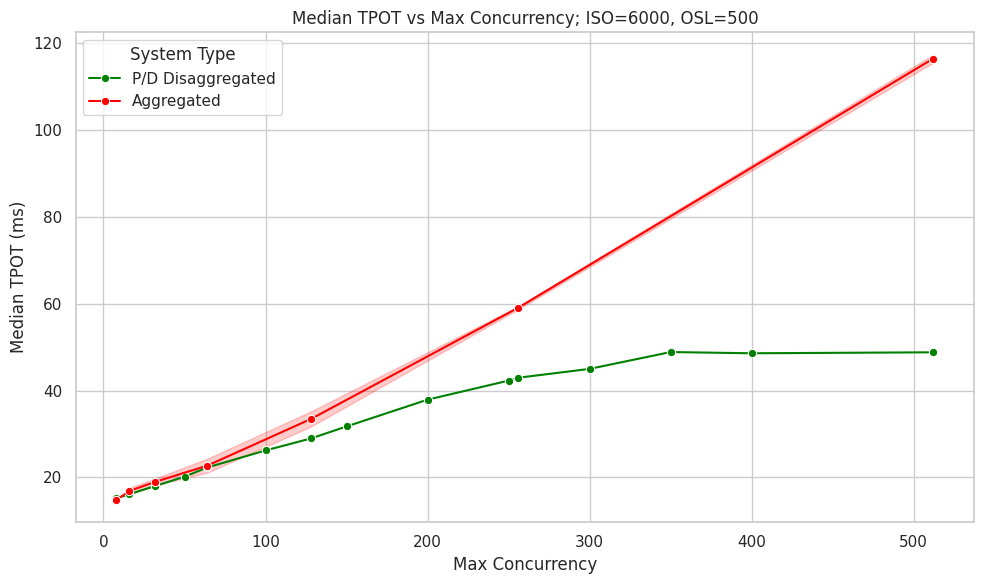

In [10]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='max_curr', y='median_tpot_ms', hue='system_type', marker='o', palette=palette)

plt.title('Median TPOT vs Max Concurrency; ISO=6000, OSL=500')
plt.xlabel('Max Concurrency')
plt.ylabel('Median TPOT (ms)')
plt.grid(True)
plt.legend(title='System Type')
plt.tight_layout()
plt.show()

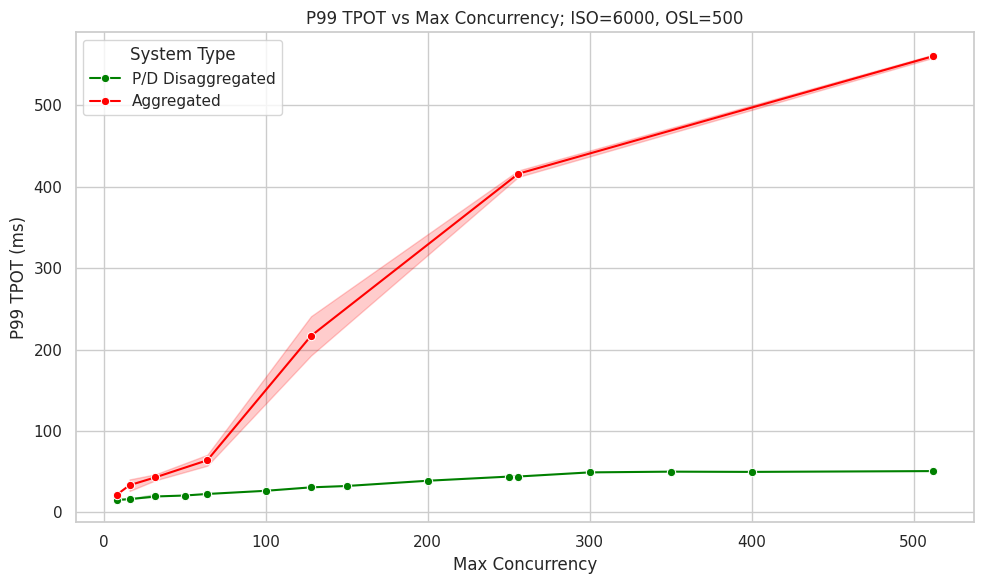

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='max_curr', y='p99_tpot_ms', hue='system_type', marker='o', palette=palette)

plt.title('P99 TPOT vs Max Concurrency; ISO=6000, OSL=500')
plt.xlabel('Max Concurrency')
plt.ylabel('P99 TPOT (ms)')
plt.grid(True)
plt.legend(title='System Type')
plt.tight_layout()
plt.show()